In [63]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not found - downloading them')
    for dfile in File:
        if not os.path.isfile(dfile):
            print("Downloading "+dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()

print('Basic file found')
%run basic_material.py


Basic file found
Running Python: 3.12.8
Running Sympy: 1.13.2
Control Package Found


In [64]:

def my_step(t,t0 = 1,val = 2):
    x = np.zeros_like(t)
    x[t >= t0] = val
    return x

def my_ramp(t,t0 = 1,t1 = 8,val = 0.8):
    '''
    0:              until t0 = 1
    val*(t-t0):     until t1 = 8
    val*(t1-t0):    after t1
    va = 0.8
    '''
    if t < t0:
        return 0
    elif t < t1:
        return val*(t-t0)
    else:
        return val*(t1-t0)
    
def my_squarewave(t, Tsw=1, Toffset = 5):
    if t <= Toffset:
        return 0    
    return 1.0 if ((t-Toffset) // Tsw) % 2 == 0 else -1.0

def smootherstep(t, t0 = 0, t1 = 1): 
    # Scale, and clamp x to 0..1 range
    if t0 == t1:
        return 0.0
    x = np.clip((t - t0) / (t1 - t0), 0.0, 1.0)
    # Evaluate polynomial
    return x * x * x * (x * (6.0*x - 15.) + 10.)

In [65]:
class PIDController:
    def __init__(self, Kp, Ki, Kd, dt, output_limits=(None, None), anti_windup=True, tau=0.1, u_eq = 0, PV = False):
        """
        PID Controller with anti-windup via back-calculation.

        Parameters:
        Kp (float): Proportional gain
        Ki (float): Integral gain
        Kd (float): Derivative gain
        dt (float): Time step
        output_limits (tuple): Min and max output limits (e.g., (0, 100))
        anti_windup (bool): Enable anti-windup
        tau (float): Anti-windup back-calculation coefficient
        u_eq (float): Equilibrium control output
        PV (bool): Process variable
        """
        self.Kp = Kp
        self.Ki = Ki*dt
        self.Kd = Kd/dt
        self.output_limits = output_limits
        self.anti_windup = anti_windup
        self.tau = tau  # Back-calculation time constant
        self.u_eq = u_eq
        self.PV = PV
        
        # Internal states
        self.I = 0.0
        self.prev_d_error = 0.0

    def compute(self, setpoint, measurement):
        """
        Compute PID output.
        Parameters:
            setpoint (float): Desired setpoint
            measurement (float): Current measurement

        Returns:
            float: PID control output
        """
        min_output, max_output = self.output_limits
        if min_output is None:
            min_output = -np.inf
        if max_output is None:
            max_output = np.inf

        # Error signal
        error = setpoint - measurement
        if self.PV: # D term doesn't use Reference
            d_error = - measurement
        else:
            d_error = error

        # Proportional term
        P = self.Kp * error
        # Derivative term (using backward difference)
        D = self.Kd * (d_error - self.prev_d_error)

        # Integral term
        self.I += self.Ki * error 

        # Raw PID output
        non_sat_output = self.u_eq + P + self.I + D # u_eq is the equilibrium control output

        sat_output = np.clip(non_sat_output, min_output, max_output)

        # Anti-windup: Back-calculation -- Apply output limits
        if self.anti_windup and (non_sat_output <= min_output or non_sat_output >= max_output):
            self.I += self.tau * (sat_output - non_sat_output) * self.Ki 

        # Store previous values
        self.prev_d_error = d_error

        return sat_output, self.I, non_sat_output

In [66]:
class System:
    def __init__(self, A, B, C, x0 = 0, dt = 0.1, input_limits=(None, None)):
        self.A = A
        self.B = B
        self.C = C
        self.x = x0
        self.dt = dt
        self.min_output,self.max_output = input_limits

    def update_dynamics(self,input):
        # make sure that what is applied atisfies the limits if they exist
        sat_input = input
        if self.min_output is not None:
            sat_input = max(self.min_output, sat_input)
        if self.max_output is not None:
            sat_input = min(self.max_output, sat_input)
        # simple integration of dynamics
        self.x += (self.A*self.x + self.B*sat_input)*self.dt        
        return 
        
    def meas_dynamics(self):
        return self.C*self.x
                

In [67]:
dt = 0.01
umin,umax = (0,1)
input_type = 1
if input_type == 1:
    Tf = 10
    val = 1.3
else:
    Tf = 20    

T = np.arange(0, Tf, dt)
sys = System(-0.1,1,1,0,dt,input_limits=(umin,umax))        
sys_no_AW = System(-0.1,1,1,0,dt,input_limits=(umin,umax))

# PID parameters
Kp = 1.0
Ki = 1.5
Kd = 0.1
tau = 1

# analyze astrom notation for PID page 79
Td = Kd/Kp
Ti = Kp/Ki
tau_proposed = 1/np.sqrt(Ki*Kd)
print(f'Td = {Td:4.2f}, Ti = {Ti:4.2f}, tau_proposed = {tau_proposed:4.2f}')

pid = PIDController(Kp, Ki, Kd, dt, output_limits=(umin, umax),anti_windup=True,tau=tau)
pid_no_AW = PIDController(Kp, Ki, Kd, dt, output_limits=(umin, umax), anti_windup=False)

outputs = []
U = []
e_int = []
measurement = 0
# Simulate PID control without anti-windup
outputs_no_AW = []
U_no_AW = []
e_int_no_AW = []
measurement_no_AW = 0
SP = []
for t in T:
    if input_type == 1:
        setpoint = my_step(t,val=val)
    else:
        setpoint = my_ramp(t)

    measurement = sys.meas_dynamics()
    control_signal, integrated_error,_ = pid.compute(setpoint, measurement)
    sys.update_dynamics(control_signal)
    
    outputs.append(measurement)
    U.append(control_signal)
    e_int.append(integrated_error)

    measurement_no_AW = sys_no_AW.meas_dynamics()
    control_signal_no_AW, integrated_error,_ = pid_no_AW.compute(setpoint, measurement_no_AW)
    sys_no_AW.update_dynamics(control_signal_no_AW)
    
    U_no_AW.append(control_signal_no_AW)
    outputs_no_AW.append(measurement_no_AW)
    e_int_no_AW.append(integrated_error)

    SP.append(setpoint)

Td = 0.10, Ti = 0.67, tau_proposed = 2.58


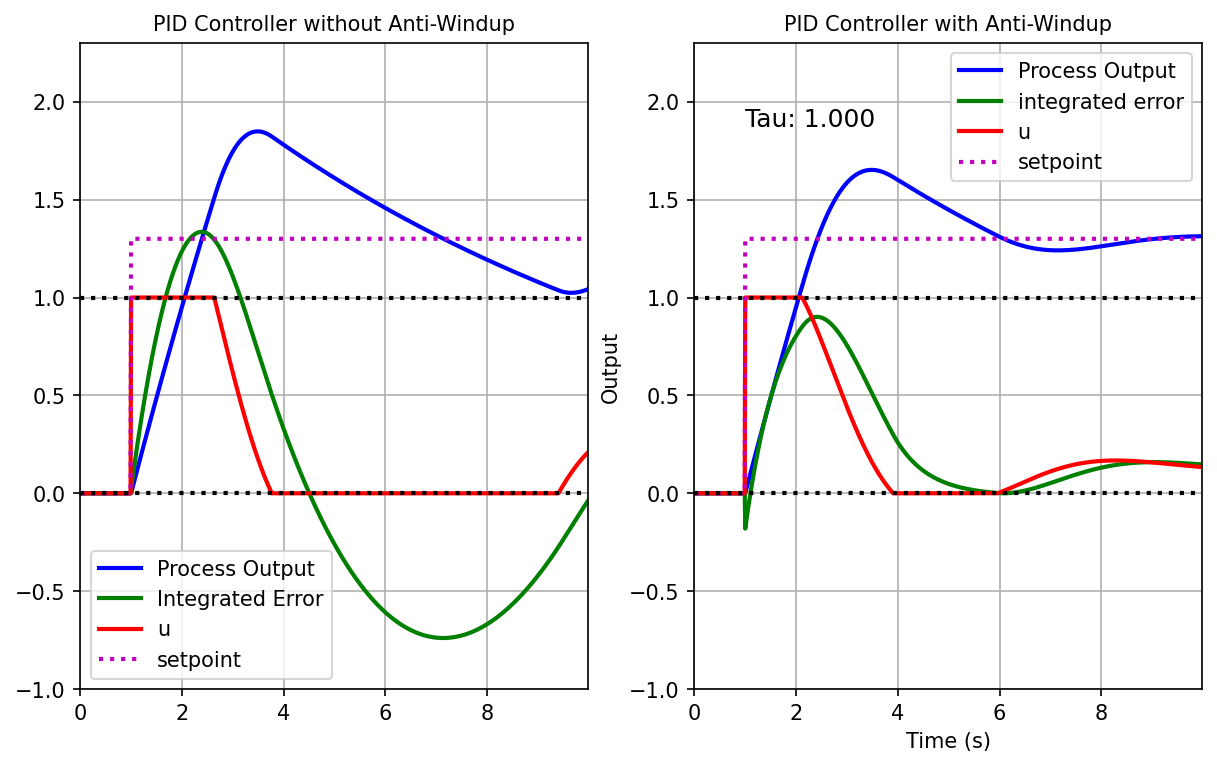

In [68]:
# Plot results
fig, ax = plt.subplots(1,2,figsize=(8, 5),dpi=150,constrained_layout = True)
ax[0].plot(T, outputs_no_AW, 'b', label="Process Output")
ax[0].plot(T, e_int_no_AW, 'g', label="Integrated Error")
ax[0].plot(T, U_no_AW, 'r', label="u")
ax[0].plot(T, SP, 'm:', label="setpoint")

ax[1].plot(T, outputs, 'b', label="Process Output")
ax[1].plot(T, e_int, 'g', label="integrated error")
ax[1].plot(T, U, 'r', label="u")
ax[1].plot(T, SP, 'm:', label="setpoint")
ax[1].text(0.1, 0.9, f'Tau: {pid.tau:4.3f}', transform=ax[1].transAxes, fontsize=12, verticalalignment='top')
plt.xlabel("Time (s)")
plt.ylabel("Output")
for ii in range(2):
    ax[ii].axhline(y=umax,color='k',ls=':')
    ax[ii].axhline(y=umin,color='k',ls=':')
    ax[ii].set_xlim(0,np.max(t))
    ax[ii].set_ylim(-1,max(SP)+1)
    ax[ii].grid(True)
    ax[ii].legend()
ax[0].set_title("PID Controller without Anti-Windup")
ax[1].set_title("PID Controller with Anti-Windup")
plt.show()

## Try Example with and without PV

In [69]:
dt = 0.01
umin,umax = (None,None)
input_type = 1
if input_type == 1:
    Tf = 10
    val = 1.3
else:
    Tf = 20    

T = np.arange(0, Tf, dt)
sys = System(-0.1,1,1,0,dt,input_limits=(umin,umax))        
sys_PV = System(-0.1,1,1,0,dt,input_limits=(umin,umax))

# PID parameters
Kp = 1.0
Ki = 1.5
Kd = 0.1
tau = 1

pid = PIDController(Kp, Ki, Kd, dt, output_limits=(umin, umax),anti_windup=False,tau=0*tau,PV=False)
pid_PV = PIDController(Kp, Ki, Kd, dt, output_limits=(umin, umax), anti_windup=False,tau=0*tau,PV=True)

outputs = []
U = []
e_int = []
measurement = 0
# Simulate PID control without anti-windup
outputs_PV = []
U_PV = []
e_int_PV = []
measurement_PV = 0
SP = []
for t in T:
    if input_type == 1:
        setpoint = my_step(t,val=val)
    else:
        setpoint = my_ramp(t)

    measurement = sys.meas_dynamics()
    control_signal, integrated_error,_ = pid.compute(setpoint, measurement)
    sys.update_dynamics(control_signal)
    
    outputs.append(measurement)
    U.append(control_signal)
    e_int.append(integrated_error)

    measurement_PV = sys_PV.meas_dynamics()
    control_signal_PV, integrated_error,_ = pid_PV.compute(setpoint, measurement_PV)
    sys_PV.update_dynamics(control_signal_PV)
    
    U_PV.append(control_signal_PV)
    outputs_PV.append(measurement_PV)
    e_int_PV.append(integrated_error)

    SP.append(setpoint)

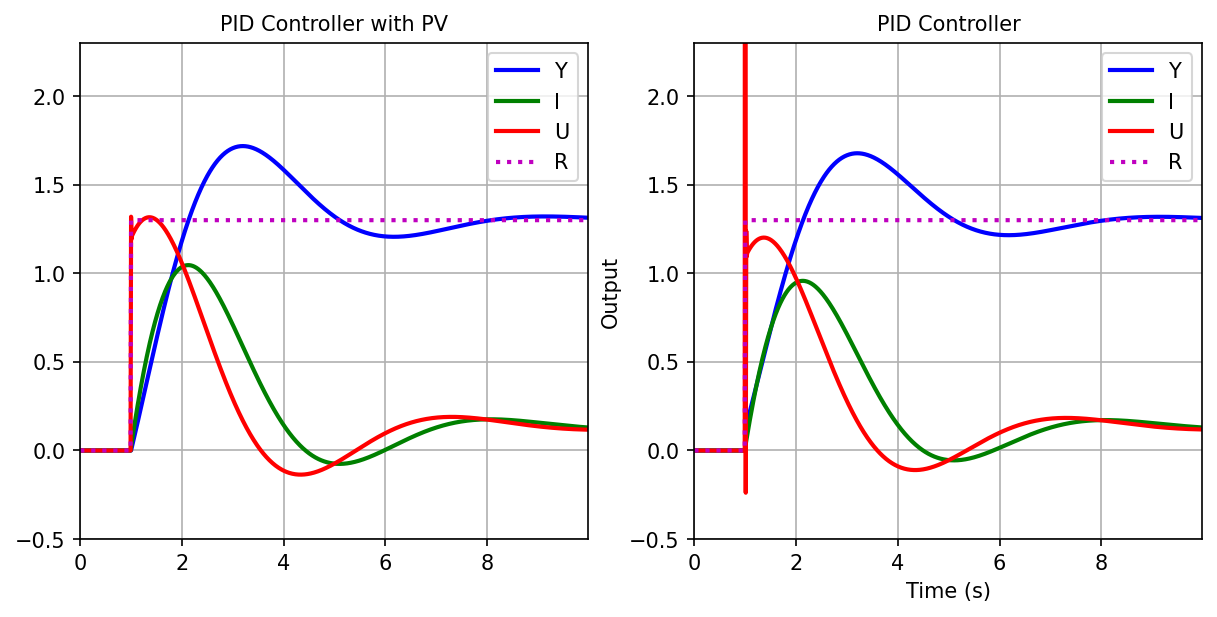

In [71]:
# Plot results
fig, ax = plt.subplots(1,2,figsize=(8, 4),dpi=150,constrained_layout = True)
ax[0].plot(T, outputs_PV, 'b', label="Y")
ax[0].plot(T, e_int_PV, 'g', label="I")
ax[0].plot(T, U_PV, 'r', label="U")
ax[0].plot(T, SP, 'm:', label="R")

ax[1].plot(T, outputs, 'b', label="Y")
ax[1].plot(T, e_int, 'g', label="I")
ax[1].plot(T, U, 'r', label="U")
ax[1].plot(T, SP, 'm:', label="R")
plt.xlabel("Time (s)")
plt.ylabel("Output")
for ii in range(2):
    if umin is not None:
        ax[ii].axhline(y=umax,color='k',ls=':')
        ax[ii].axhline(y=umin,color='k',ls=':')
    ax[ii].set_xlim(0,np.max(t))
    ax[ii].set_ylim(-0.5,max(SP)+1)
    ax[ii].grid(True)
    ax[ii].legend()
ax[0].set_title("PID Controller with PV")
ax[1].set_title("PID Controller")
savefig("./figs/PV_ex1.pdf", dpi=600)
plt.show()

## Car AW  Example

In [6]:
from math import copysign, sin
sign = lambda x: copysign(1, x)         # define the sign() function
import numpy as np

class Car:
    def __init__(self, v_ref = 25, dt = 0.1, ulims=(0,1), gear= 4, theta0 = 0):
        self.dt = dt
        self.m = 1500 # vehicle mass, kg
        self.g = 9.81 # gravitational constant, m/s^2
        self.Cr = 0.01 # coefficient of rolling friction
        self.Cd = 0.32 # drag coefficient
        self.rho = 1.2 # density of air, kg/m^3
        self.A = 0.79/self.Cd # car area, m^2
        self.alpha = [40, 25, 16, 12, 10] # gear ratio / wheel radius
        self.Tm = 190.        # engine torque constant
        self.omega_m = 420.   # peak engine angular speed
        self.beta = 0.4       # peak engine rolloff
        self.gear = gear
        self.v = v_ref # set IC
        self.v_ref = v_ref # used in eq calc
        self.theta = theta0
        self.u_eq = 0 # computed later
        self.u_min,self.u_max = ulims
        self.first = 10 # switch to see things
        
    def find_eq(self):
        Fg = self.m * self.g * sin(self.theta)
        Fr  = self.m * self.g * self.Cr * sign(self.v_ref)
        Fa = 1/2 * self.rho * self.Cd * self.A * abs(self.v_ref) * self.v_ref
        Fd = Fg + Fr + Fa
        omega = self.alpha[int(self.gear)-1] * self.v_ref      # engine angular speed
        self.u_eq = Fd/(self.alpha[int(self.gear)-1] * self.motor_torque(omega))
        #self.u_eq = (1/2 * self.rho * self.Cd * self.A * abs(self.v) * self.v + self.m * self.g * self.Cr * sign(self.v))/(self.alpha[int(self.gear)-1] * self.motor_torque(self.alpha[int(self.gear)-1] * self.v))
        return self.alpha[int(self.gear)-1] * self.motor_torque(omega) * self.u_eq
        
    def vehicle_update(self, u = 0, theta = 0):
        """Vehicle dynamics for cruise control system.
        """
        throttle = np.clip(u, self.u_min, self.u_max)     # vehicle throttle

        # Force generated by the engine
        omega = self.alpha[int(self.gear)-1] * self.v      # engine angular speed
        F = self.alpha[int(self.gear)-1] * self.motor_torque(omega) * throttle

        # Disturbance forces
        # The disturbance force Fd has three major components: Fg, the forces due
        # to gravity; Fr, the forces due to rolling friction; and Fa, the
        # aerodynamic drag.
        # Letting the slope of the road be \theta (theta), gravity gives the
        # force Fg = m g sin \theta.
        Fg = self.m * self.g * sin(theta)

        # A simple model of rolling friction is Fr = m g Cr sgn(v), where Cr is
        # the coefficient of rolling friction and sgn(v) is the sign of v (±1) or
        # zero if v = 0.
        Fr  = self.m * self.g * self.Cr * sign(self.v)

        # The aerodynamic drag is proportional to the square of the speed: Fa =
        # 1/2 \rho Cd A |v| v, where \rho is the density of air, Cd is the
        # shape-dependent aerodynamic drag coefficient, and A is the frontal area
        # of the car.
        Fa = 1/2 * self.rho * self.Cd * self.A * abs(self.v) * self.v
        
        # Final acceleration on the car
        Fd = Fg + Fr + Fa
        dv = (F - Fd) / self.m
        if self.first < 5:
            print(dv,self.v,self.v_ref,throttle)
            self.first += 1

        self.v += dv*self.dt
        return 

    def motor_torque(self,omega):
        # Set up the system parameters
        return np.clip(self.Tm * (1 - self.beta * (omega/self.omega_m - 1)**2), 0, None)
    
def hill(angle = [0,4,0], t_start = 5, t_stop = 15):
    theta_hill = [
        angle[0] if t <= t_start else
        angle[1]/180. * np.pi * (t-t_start) if t <= (t_start+1.0) else
        angle[1]/180. * np.pi if t <= t_stop else
        angle[1]/180. * np.pi *(1.0 - (t - t_stop)) if t <= (t_stop + 1.0) else
        angle[2]/180. * np.pi for t in T]
    return np.array(theta_hill)


In [7]:
# Define the time and input vectors
Tf = 30; Npts = 1000
t_start = 2 # hill related
t_stop = 20

KP = 1.5 #Pgain
KI = 1.5 #Igain
KAW = 2.00 # AW gain
ulims = (0,1)

T = np.linspace(0, Tf, Npts)
dt = T[1] - T[0]
vref = 25 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta0 = np.zeros(T.shape)

car = Car(vref[0],gear = gear[0],dt=dt,ulims=ulims)
F_eq = car.find_eq()
print(f"Ueq = {car.u_eq:4.3f}")
print(f"Feq = {F_eq:4.3f}")
#car.vehicle_update()

theta_hill = hill(angle=[0,4,0],t_start=t_start,t_stop=t_stop)
theta_hill_small = hill(angle=[0,5,0],t_start=t_start,t_stop=t_stop)
theta_hill_big = hill(angle=[0,6.5,0],t_start=t_start,t_stop=t_stop)


Ueq = 0.201
Feq = 443.400


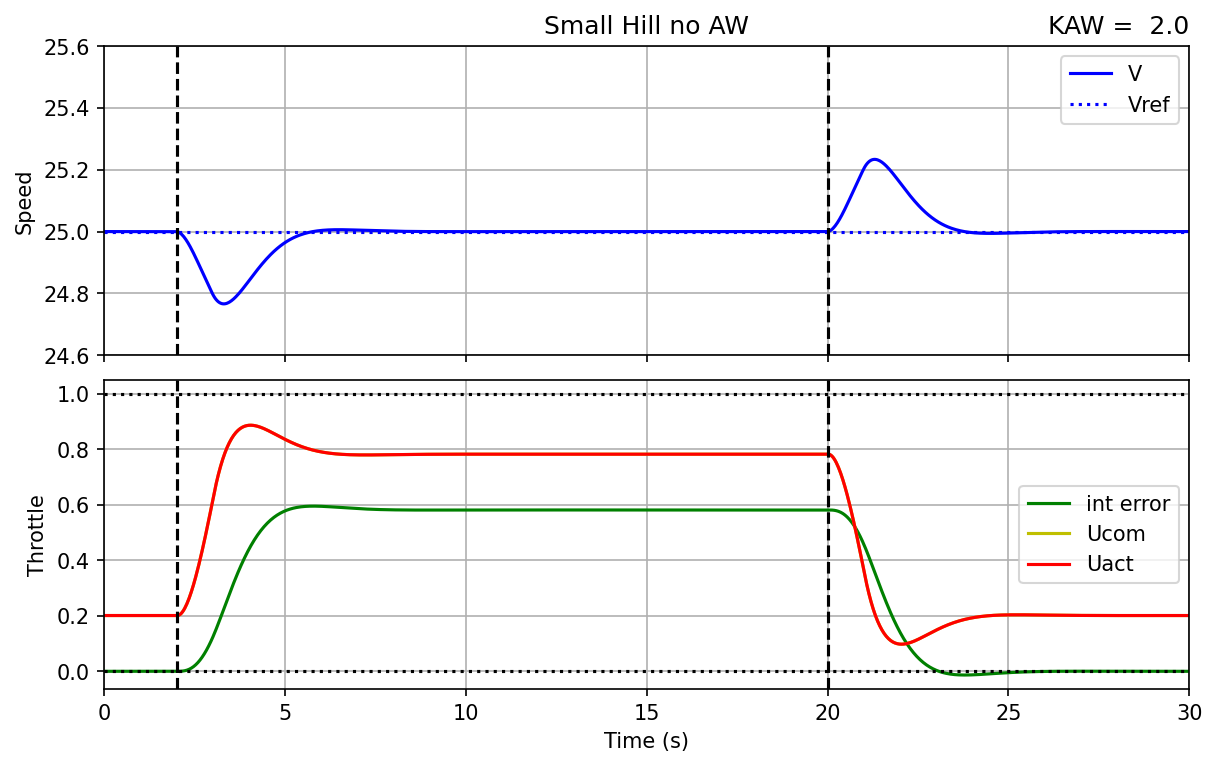

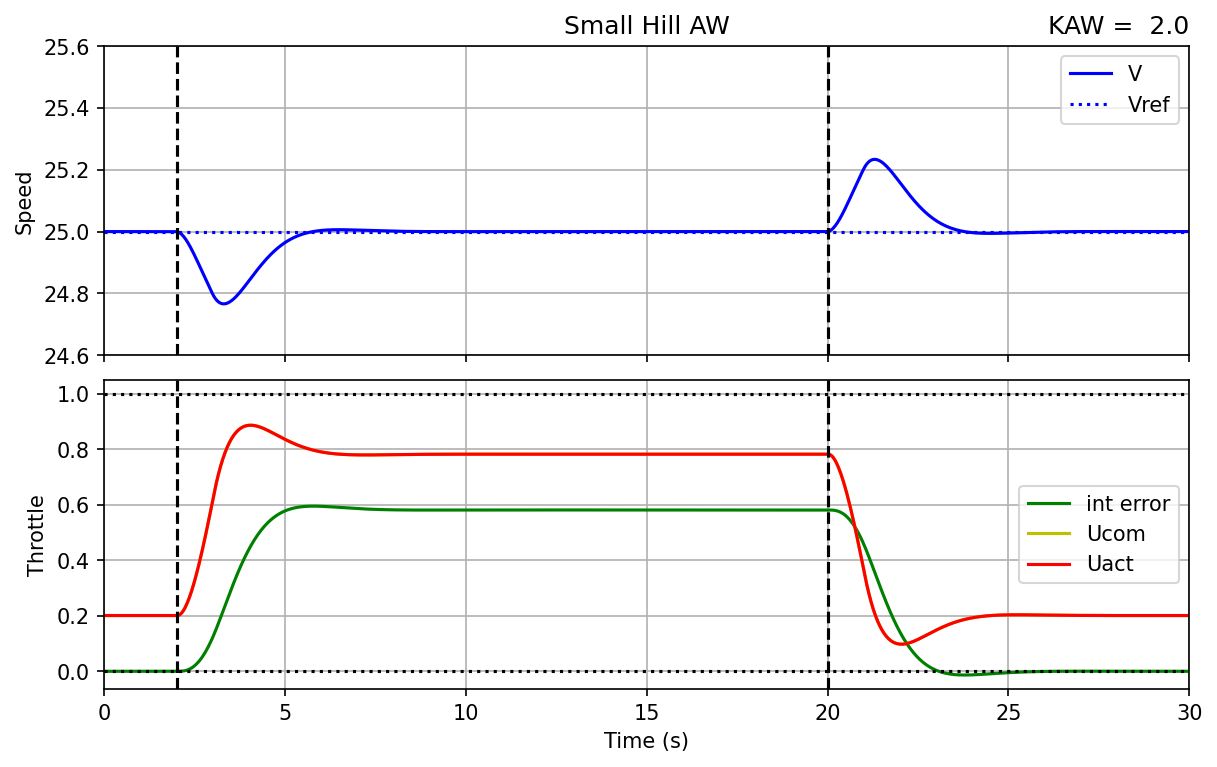

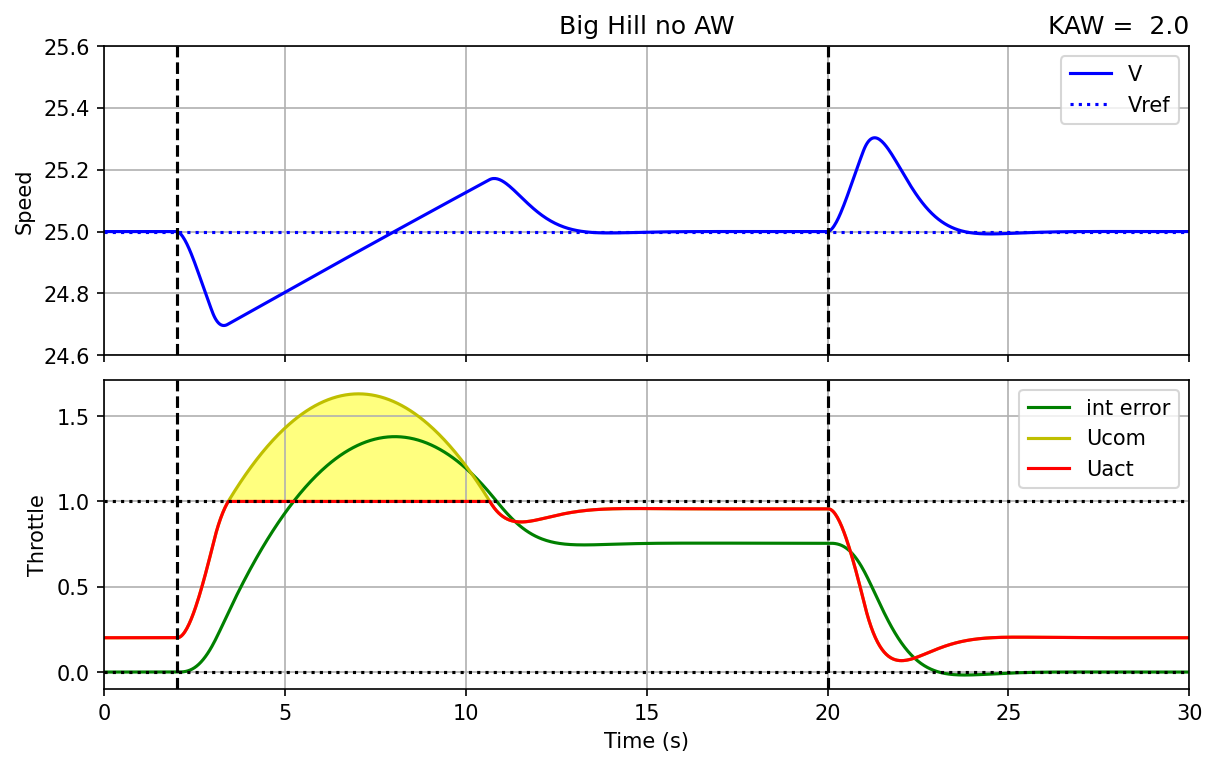

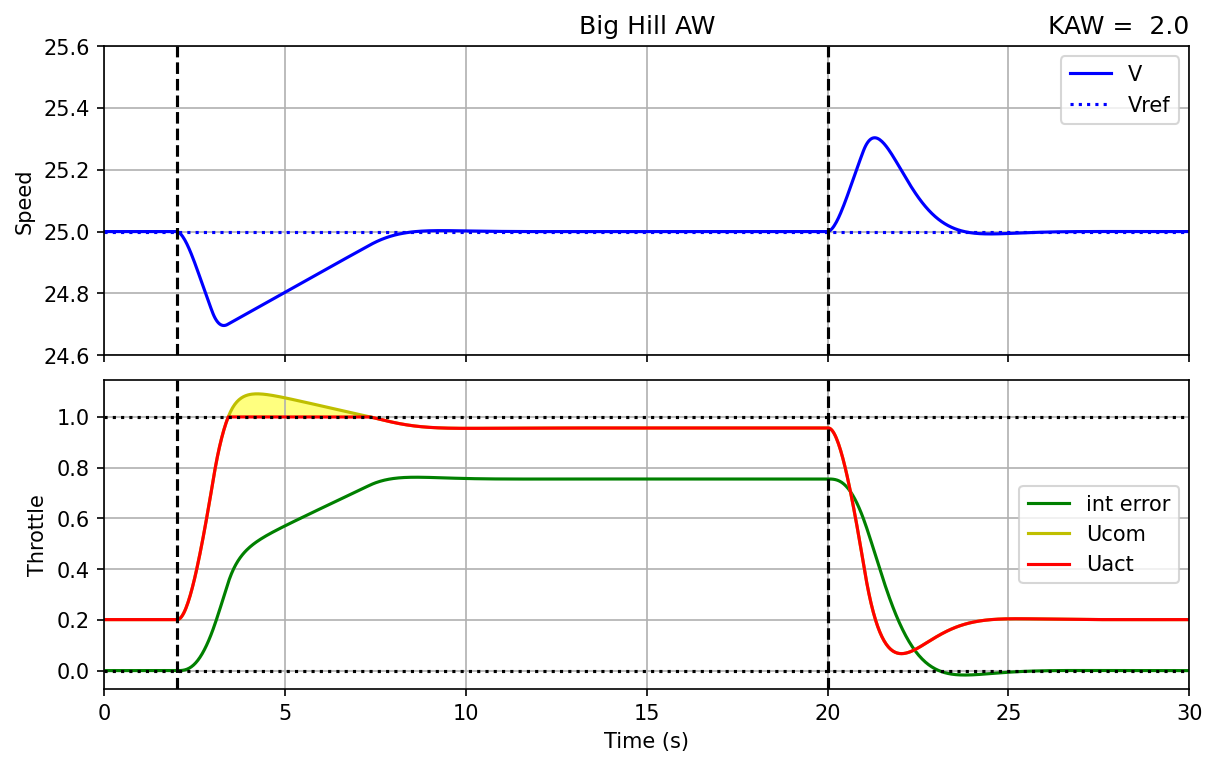

In [8]:
for case in range(4):
    if case == 0: # small hill no AW
        pid = PIDController(KP, KI, 0, dt, output_limits=ulims,anti_windup=False,tau = KAW, u_eq = car.u_eq)
        xhill = theta_hill_small
        plt_title = "Small Hill no AW"
        filename = "small_hill_no_AW.pdf"

    if case == 1: # small hill AW
        pid = PIDController(KP, KI, 0, dt, output_limits=ulims,anti_windup=True,tau = KAW, u_eq = car.u_eq)
        xhill = theta_hill_small
        plt_title = "Small Hill AW"
        filename = "small_hill_AW.pdf"

    if case == 2: # big hill no AW
        pid = PIDController(KP, KI, 0, dt, output_limits=ulims,anti_windup=False,tau = KAW, u_eq = car.u_eq)
        xhill = theta_hill_big
        plt_title = "Big Hill no AW"
        filename = "big_hill_no_AW.pdf"

    if case == 3: # big hill AW
        pid = PIDController(KP, KI, 0, dt, output_limits=ulims,anti_windup=True,tau = KAW, u_eq = car.u_eq)
        xhill = theta_hill_big
        plt_title = "Big Hill AW"
        filename = "big_hill_AW.pdf"
    
    outputs = []
    Ucom = []
    Uact = []
    e_int = []

    for kk,t in enumerate(T):

        control_signal, integrated_error,u_com = pid.compute(car.v_ref, car.v)
        if car.first < 5:
            print("u = ",control_signal)

        car.vehicle_update(u = control_signal, theta = xhill[kk])
        
        outputs.append(car.v)
        Uact.append(control_signal)
        Ucom.append(u_com)
        e_int.append(integrated_error)

    Uact = np.array(Uact)
    Ucom = np.array(Ucom)

    # Plot results
    fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True, sharex=True)
    ax[0].plot(T, outputs, 'b', label="V")
    ax[0].plot(T, vref, 'b:', label="Vref")
    ax[1].plot(T, e_int, 'g', label="int error")
    ax[1].plot(T, Ucom, 'y', label="Ucom")
    ax[1].plot(T, Uact, 'r', label="Uact")
    # Fill the area between Ucom and Uact
    ax[1].fill_between(T, Ucom, Uact, where=(Ucom > Uact), facecolor='yellow', alpha=0.5, interpolate=True)
    #ax[1].fill_between(T, Ucom, Uact, where=(Ucom <= Uact), facecolor='blue', alpha=0.5, interpolate=True, label="Ucom <= Uact")
    ax[1].axhline(y=car.u_max,c='k',ls=':')
    ax[1].axhline(y=car.u_min,c='k',ls=':')
    ax[0].set_title(plt_title)
    for ii in range(2):
        ax[ii].axvline(x=t_start,c='k',ls='--')
        ax[ii].axvline(x=t_stop,c='k',ls='--')
        ax[ii].grid()
    ax[0].set_title(f"{KAW = :4.1f}",loc='right')
    ax[1].set_xlabel("Time (s)")
    ax[0].set_ylabel("Speed")
    ax[1].set_ylabel("Throttle")
    ax[0].set_xlim(0,max(T))
    ax[0].set_ylim(car.v_ref-.4,car.v_ref+.6)
    ax[1].set_xlim(0,max(T))
    ax[0].legend()
    ax[1].legend()

    plt.savefig("./figs/"+filename, dpi=600)
    plt.show()

In [9]:
class PIDController_Tustin:
    def __init__(self, Kp, Ki, Kd, dt, output_limits=(None, None), anti_windup=True, tau=0.1, u_eq = 0):
        """
        PID Controller with anti-windup via back-calculation.

        Parameters:
        Kp (float): Proportional gain
        Ki (float): Integral gain
        Kd (float): Derivative gain
        dt (float): Time step
        output_limits (tuple): Min and max output limits (e.g., (0, 100))
        anti_windup (bool): Enable anti-windup
        tau (float): Anti-windup back-calculation coefficient
        u_eq (float): Equilibrium control output
        wc: Pre-warping frequency (rad/s) - default is 0
        """
        self.dt = dt
        self.Kp = Kp
        self.Ki = Ki   # Integral term coefficient
        self.Kd = Kd   # Derivative term coefficient
        self.deriv_filter_tau = 0.02  # Back-calculation time constant

        self.output_limits = output_limits
        self.anti_windup = anti_windup
        self.tau = tau  # Back-calculation time constant
        self.u_eq = u_eq
        self.alpha = 1 # actuator guard value <= 1

        # Internal states
        self.I = 0.0
        self.prev_error = 0.0
        self.prev_deriv = 0.0
        self.prev_u_error = 0.0
        self.prev_output = 0.0

    def compute(self, setpoint, measurement):
        """
        Compute PID output.
        Parameters:
            setpoint (float): Desired setpoint
            measurement (float): Current measurement

        Returns:
            float: PID control output
        """
        min_output, max_output = self.output_limits

        # Error signal
        error = setpoint - measurement

        # Proportional term
        P = self.Kp * error

        # Derivative term (using backward difference)
        D = 2.0*self.Kd/(2*self.deriv_filter_tau + self.dt)*(error - self.prev_error) + self.prev_deriv*(2*self.deriv_filter_tau - self.dt)/(2*self.deriv_filter_tau + self.dt) 

        # Integral term
        self.I += self.Ki * (error + self.prev_error) * self.dt / 2.0

        # Raw PID output
        non_sat_output = self.u_eq + P + self.I + D # u_eq is the equilibrium control output

        sat_output = np.clip(non_sat_output, min_output, max_output)

        # Anti-windup: Back-calculation -- Apply output limits
        if self.anti_windup and (non_sat_output <= min_output or non_sat_output >= max_output):
            u_error = sat_output - non_sat_output
            self.I += self.tau * (u_error + self.prev_u_error) * self.Ki * self.dt / 2.0
            self.prev_u_error = u_error # only update if it is used 

        # Store previous values
        self.prev_error = error
        self.prev_deriv = D
        self.prev_output = sat_output

        return sat_output, self.I, non_sat_output

In [10]:
dt = 0.01
umin,umax = (0,1)
input_type = 1
if input_type == 1:
    Tf = 15
    val = 1.1
else:
    Tf = 20    

T = np.arange(0, Tf, dt)
sys = System(-0.1,1,1,0,dt,input_limits=(umin,umax))        
sys_no_AW = System(-0.1,1,1,0,dt,input_limits=(umin,umax))

# PID parameters
Kp = 1.0
Ki = 1.5
Kd = 0.1
tau = .75

pid = PIDController_Tustin(Kp, Ki, Kd, dt, output_limits=(umin, umax),anti_windup=True,tau=tau)
pid_no_AW = PIDController(Kp, Ki, Kd, dt, output_limits=(umin, umax),anti_windup=False,tau=tau)

outputs = []
U = []
e_int = []
measurement = 0
# Simulate PID control without anti-windup
outputs_no_AW = []
U_no_AW = []
e_int_no_AW = []
measurement_no_AW = 0
SP = []
for t in T:
    if input_type == 1:
        setpoint = my_step(t,val=val)
    else:
        setpoint = my_ramp(t)

    measurement = sys.meas_dynamics()
    control_signal, integrated_error,_ = pid.compute(setpoint, measurement)
    sys.update_dynamics(control_signal)
    
    outputs.append(measurement)
    U.append(control_signal)
    e_int.append(integrated_error)

    control_signal_no_AW, integrated_error,_ = pid_no_AW.compute(setpoint, measurement_no_AW)
    sys_no_AW.update_dynamics(control_signal_no_AW)
    measurement_no_AW = sys_no_AW.meas_dynamics()
    
    U_no_AW.append(control_signal_no_AW)
    outputs_no_AW.append(measurement_no_AW)
    e_int_no_AW.append(integrated_error)

    SP.append(setpoint)

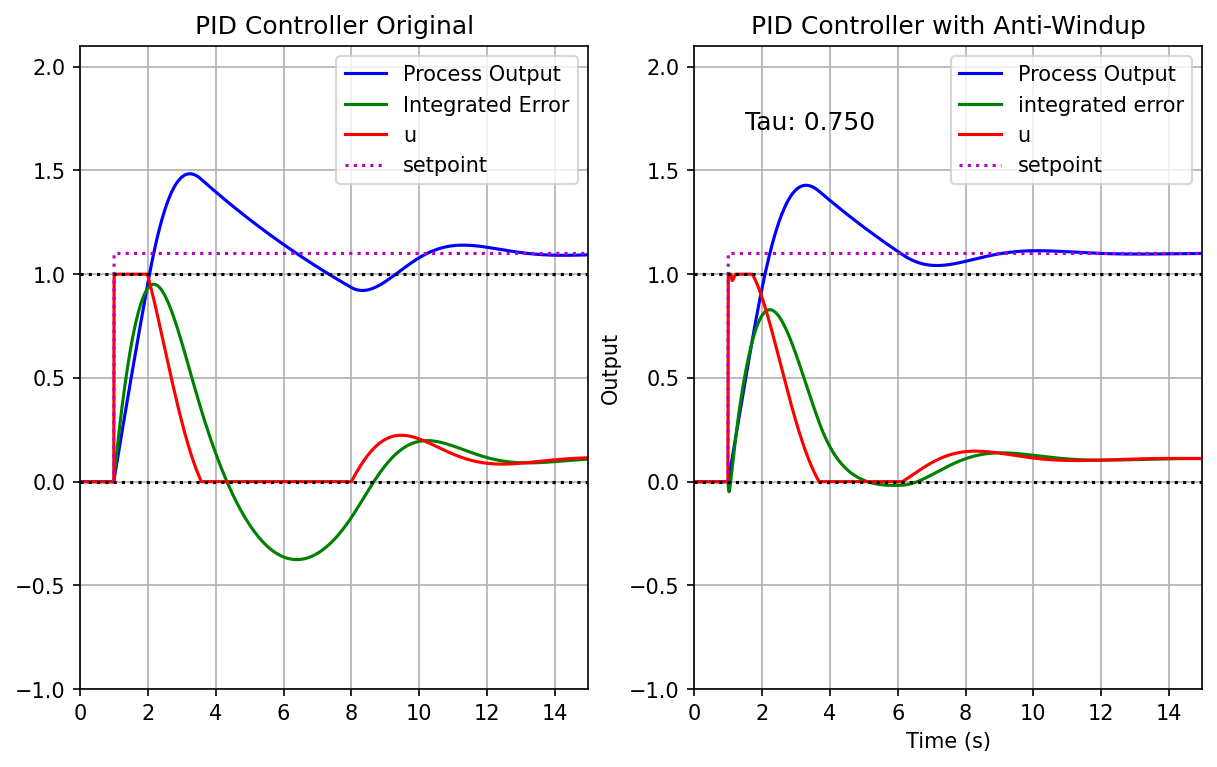

In [11]:
# Plot results
fig, ax = plt.subplots(1,2,figsize=(8, 5),dpi=150,constrained_layout = True)
ax[0].plot(T, outputs_no_AW, 'b', label="Process Output")
ax[0].plot(T, e_int_no_AW, 'g', label="Integrated Error")
ax[0].plot(T, U_no_AW, 'r', label="u")
ax[0].plot(T, SP, 'm:', label="setpoint")

ax[1].plot(T, outputs, 'b', label="Process Output")
ax[1].plot(T, e_int, 'g', label="integrated error")
ax[1].plot(T, U, 'r', label="u")
ax[1].plot(T, SP, 'm:', label="setpoint")
ax[1].text(0.1, 0.9, f'Tau: {pid.tau:4.3f}', transform=ax[1].transAxes, fontsize=12, verticalalignment='top')
plt.xlabel("Time (s)")
plt.ylabel("Output")
for ii in range(2):
    ax[ii].axhline(y=umax,color='k',ls=':')
    ax[ii].axhline(y=umin,color='k',ls=':')
    ax[ii].set_xlim(0,np.max(t))
    ax[ii].set_ylim(-1,max(SP)+1)
    ax[ii].grid(True)
    ax[ii].legend()
ax[0].set_title("PID Controller Original")
ax[1].set_title("PID Controller with Anti-Windup")
plt.show()

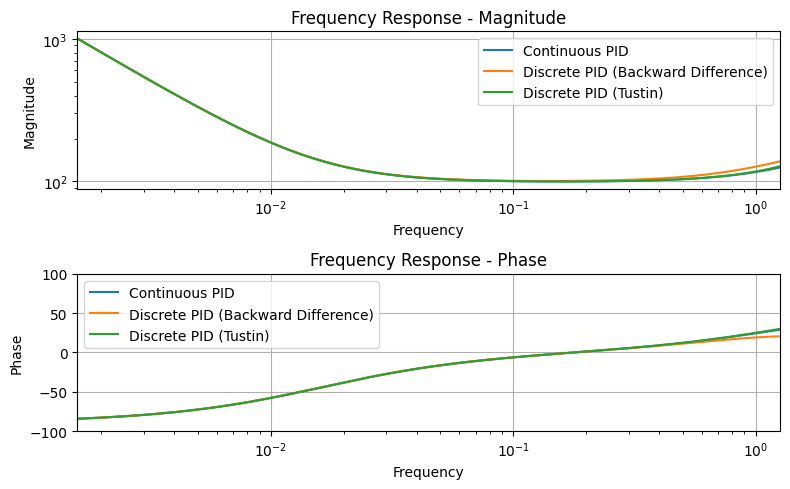

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
from control import matlab

# Continuous-time PID controller parameters
Kp = 100.0
Ki = Kp/10
Kd = 0.1*Kp
tau = 0.02

# Continuous-time PID transfer function
num = [Kd, Kp, Ki]
den = np.convolve([1, 0], [tau, 1])
sys_cont = ctrl.TransferFunction(num, den)

# Sampling time
dt = 0.1

# Discretize using backward difference
sys_discrete_backward = ctrl.sample_system(sys_cont, dt, method='backward_diff')

# Discretize using Tustin transform
sys_discrete_tustin = ctrl.sample_system(sys_cont, dt, method='bilinear')

# Frequency response
w = np.logspace(-2, np.log10(2*np.pi/dt)/2, 1000)
f = w/(2*np.pi)
mag_cont, phase_cont, _ = ctrl.frequency_response(sys_cont, w)
mag_discrete_backward, phase_discrete_backward, _ = ctrl.frequency_response(sys_discrete_backward, w)
mag_discrete_tustin, phase_discrete_tustin, _ = ctrl.frequency_response(sys_discrete_tustin, w)

# Plot frequency response
plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
plt.loglog(f, mag_cont, label='Continuous PID')
plt.loglog(f, mag_discrete_backward, label='Discrete PID (Backward Difference)')
plt.loglog(f, mag_discrete_tustin, label='Discrete PID (Tustin)')
plt.title('Frequency Response - Magnitude')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()
plt.xlim(min(f),max(f))
#plt.ylim(.1,100)
plt.grid()

r2d = 180/np.pi
plt.subplot(2, 1, 2)
plt.semilogx(f, r2d*phase_cont, label='Continuous PID')
plt.semilogx(f, r2d*phase_discrete_backward, label='Discrete PID (Backward Difference)')
plt.semilogx(f, r2d*phase_discrete_tustin, label='Discrete PID (Tustin)')
plt.title('Frequency Response - Phase')
plt.xlabel('Frequency')
plt.ylabel('Phase')
plt.legend()
plt.xlim(min(f),max(f))
plt.ylim(-100,100)
plt.grid()

plt.tight_layout()
plt.show()

## Higher Dimension systems

In [13]:
class System2:
    def __init__(self, A, B, C, x0=None, dt=0.01, _umin = 0, _umax = 1):
        self.A = A
        self.B = B
        self.C = C
        self.dt = dt
        self.umin = _umin
        self.umax = _umax
        self.x = x0.astype(np.float64) if x0 is not None else np.zeros((A.shape[0], 1), dtype=np.float64)

    def update_dynamics(self, u):
        self.x += self.dt * (self.A @ self.x + self.B * np.clip(u, self.umin, self.umax))

    def meas_dynamics(self):
        return (self.C @ self.x)[0][0]

# Define the state-space matrices
A = np.array([[ -18.000, -131.000, -426.000, -600.000, -288.000],
              [   1.000,    0.000,    0.000,    0.000,    0.000],
              [   0.000,    1.000,    0.000,    0.000,    0.000],
              [   0.000,    0.000,    1.000,    0.000,    0.000],
              [   0.000,    0.000,    0.000,    1.000,    0.000]])

B = np.array([[   1.000],
              [   0.000],
              [   0.000],
              [   0.000],
              [   0.000]])

C = np.array([[   0.000,    0.000,    1.000,  -12.000,   48.000]])

x0 = np.array([[0.], [0.], [0.], [0.], [0.]], dtype=float).reshape(5, 1)

dt = 0.001


In [38]:
umin,umax = (-6,6)
sys = System2(A,B,C,x0,dt,umin,umax)        
sys_no_AW = System2(A,B,C,x0,dt,umin,umax)

Tf = 40
T = np.arange(0, Tf, dt)

input_type = 2
if input_type == 0:
    val = 1.1
    step = val*my_step(T,5)
if input_type == 1:
    val = 0.5
else:
    Toffset = 2
    Tsw = 10
    Tdel = 0.1
    val0 = 1.4
    smooth_square = 0.0
    for ii in range(int(Tf/Tsw)+1):
        Tstart = Toffset + ii*Tsw
        Tend = Tstart + Tdel
        if ii == 0:
            val = val0
        elif ii%2 == 1:
            val = -2*val0
        else:
            val = 2*val0
        smooth_square += val*smootherstep(T,Tstart,Tend) 

# PID parameters
Kp = 8.7
Ki = 5.24
Kd = 3.7
tau = .15

pid = PIDController(Kp, Ki, Kd, dt, output_limits=(umin, umax),anti_windup=True,tau=tau,PV=True)
pid_no_AW = PIDController(Kp, Ki, Kd, dt, output_limits=(umin, umax),anti_windup=False,tau=0,PV=True)

outputs = []
U = []
UC = []
e_int = []
measurement = 0.
# Simulate PID control without anti-windup
outputs_no_AW = []
U_no_AW = []
UC_no_AW = []
e_int_no_AW = []
measurement_no_AW = 0.
SP = []
for kk,t in enumerate(T):
    if input_type == 0:
        setpoint = step[kk]
    elif input_type == 1:
        setpoint = my_ramp(t,t0=1,t1=20,val=val)
    else:
        setpoint = smooth_square[kk]
       
    measurement = sys.meas_dynamics()
    control_signal, integrated_error, commanded = pid.compute(setpoint, measurement)
    sys.update_dynamics(np.array(control_signal))
    
    outputs.append(measurement)
    U.append(control_signal)
    UC.append(commanded)
    e_int.append(integrated_error)

    measurement_no_AW = sys_no_AW.meas_dynamics()
    control_signal_no_AW, integrated_error_no_AW, commanded_no_AW = pid_no_AW.compute(setpoint, measurement_no_AW)
    sys_no_AW.update_dynamics(np.array(control_signal_no_AW))
     
    U_no_AW.append(control_signal_no_AW)
    UC_no_AW.append(commanded_no_AW)
    outputs_no_AW.append(measurement_no_AW)
    e_int_no_AW.append(integrated_error_no_AW)

    SP.append(setpoint)

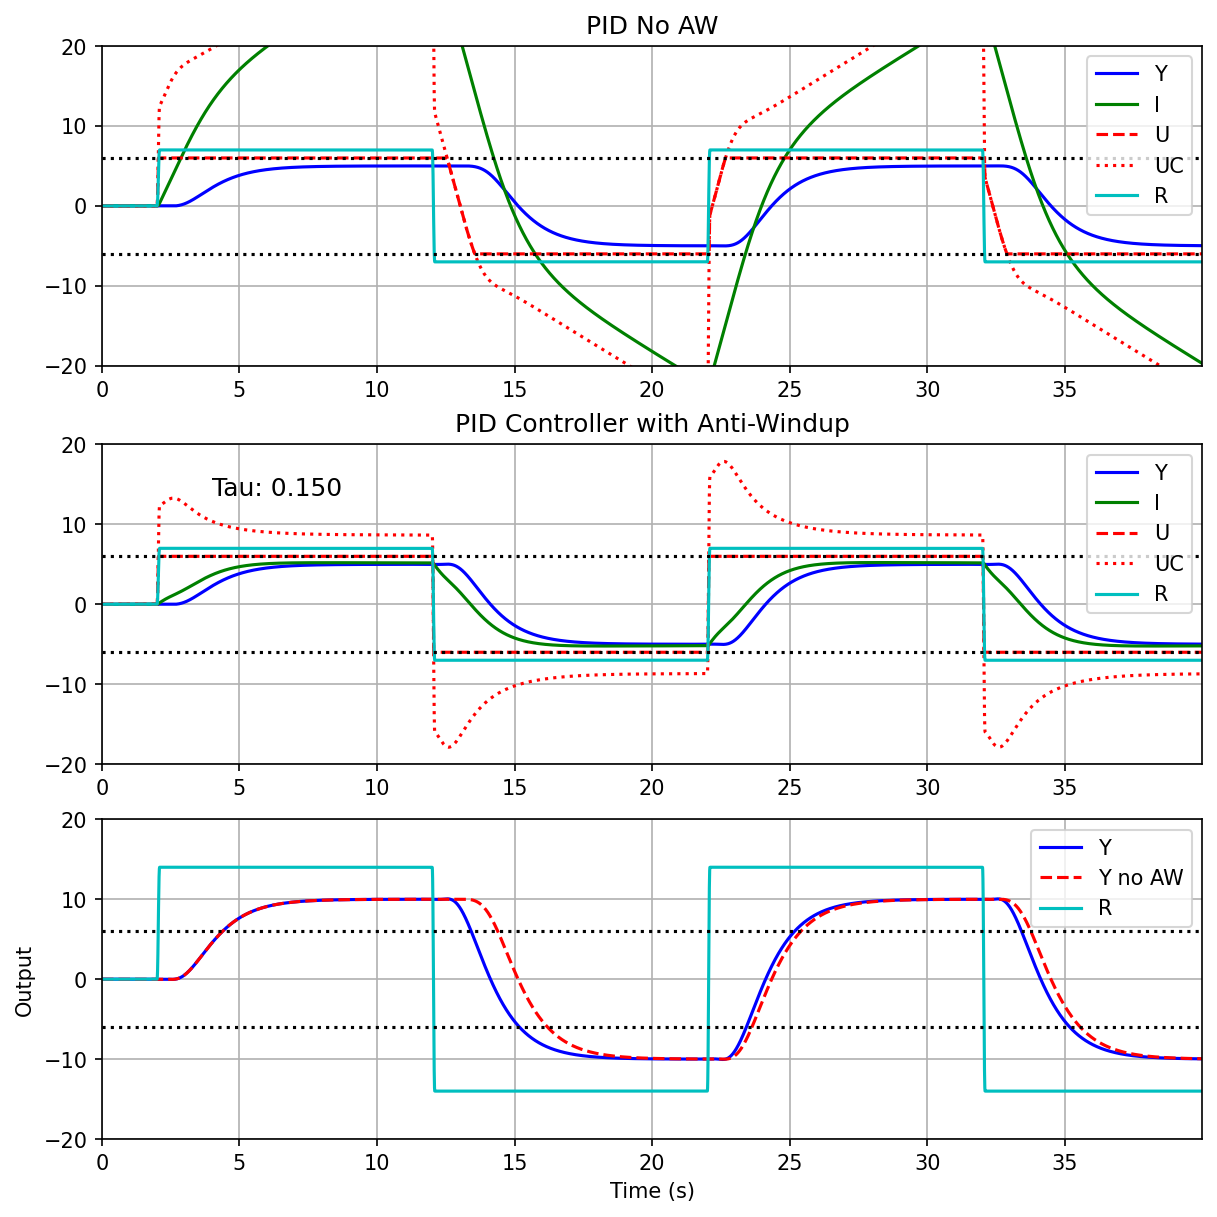

In [39]:
gamma = np.array(5)
# Plot results
fig, ax = plt.subplots(3,1,figsize=(8, 8),dpi=150,constrained_layout = True)
ax[0].plot(T, gamma*outputs_no_AW, 'b', label="Y")
ax[0].plot(T, e_int_no_AW, 'g', label="I")
ax[0].plot(T, U_no_AW, 'r--', label="U")
ax[0].plot(T, UC_no_AW, 'r:', label="UC")
ax[0].plot(T, gamma*SP, 'c-', label="R")
ax[0].set_title("PID No AW")

ax[1].set_title("PID Controller with Anti-Windup")
ax[1].plot(T, gamma*outputs, 'b', label="Y")
ax[1].plot(T, e_int, 'g', label="I")
ax[1].plot(T, U, 'r--', label="U")
ax[1].plot(T, UC, 'r:', label="UC")
ax[1].plot(T, gamma*SP, 'c-', label="R")
ax[1].text(0.1, 0.9, f'Tau: {pid.tau:4.3f}', transform=ax[1].transAxes, fontsize=12, verticalalignment='top')
plt.xlabel("Time (s)")
plt.ylabel("Output")

gamma = np.array(10)
ax[2].plot(T, gamma*outputs, 'b', label="Y")
ax[2].plot(T, gamma*outputs_no_AW, 'r--', label="Y no AW")
ax[2].plot(T, gamma*SP, 'c-', label="R")

for ii in range(3):
    ax[ii].axhline(y=umax,color='k',ls=':')
    ax[ii].axhline(y=umin,color='k',ls=':')
    ax[ii].set_xlim(0,np.max(t))
    ax[ii].set_ylim(-20,20)
    ax[ii].grid(True)
    ax[ii].legend()
plt.show()

In [17]:
val

-2.0